In [57]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [58]:
from spectral_clustering import *
from stability_analysis import *
from parameter_fitting import *
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd

In [59]:
import warnings

warnings.filterwarnings(
    "ignore", message="KMeans is known to have a memory leak on Windows with MKL"
)

In [60]:
data = pd.read_csv(project_root + "/Data/glass.csv")

In [61]:
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(columns=["Type"]).to_numpy())
y_true = data["Type"].to_numpy()

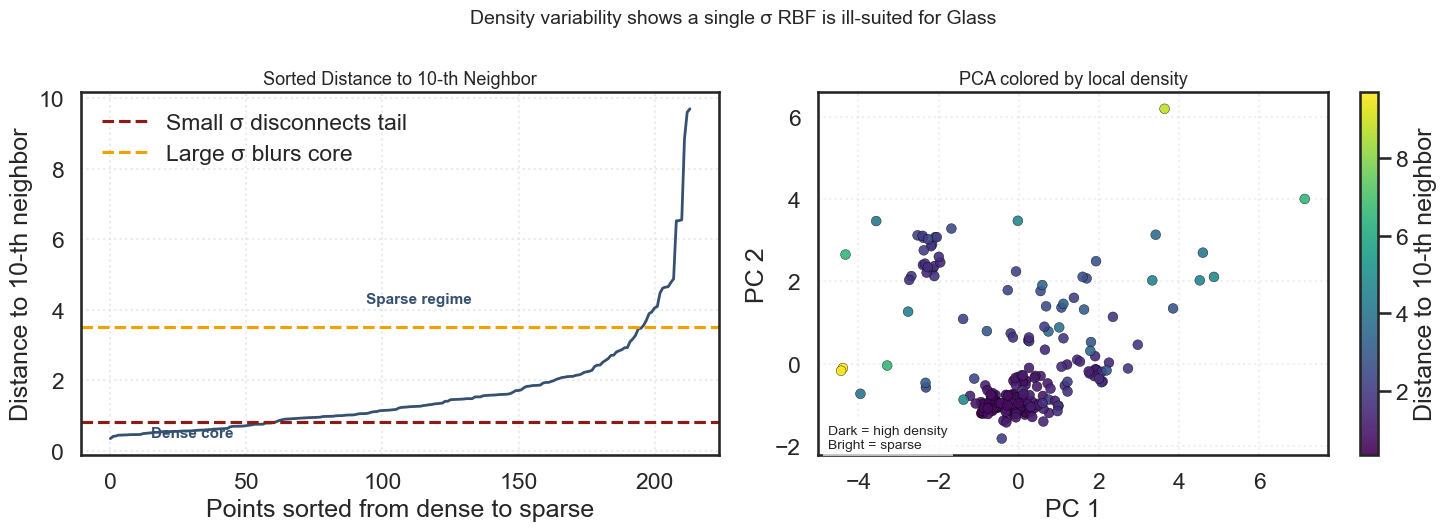

In [62]:
# Diagnose density variability to justify non-RBF graph choices
k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, _ = nbrs.kneighbors(X)
dist_to_kth_neighbor = distances[:, k - 1]
sorted_distances = np.sort(dist_to_kth_neighbor)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5.5))

ax1.plot(sorted_distances, color="#355070", linewidth=2)
ax1.set_title(f"Sorted Distance to {k}-th Neighbor", fontsize=13)
ax1.set_xlabel("Points sorted from dense to sparse")
ax1.set_ylabel(f"Distance to {k}-th neighbor")
ax1.grid(True, linestyle=":", alpha=0.4)
ax1.axhline(0.8, color="#8C1C13", linestyle="--", label="Small σ disconnects tail")
ax1.axhline(3.5, color="#F0A202", linestyle="--", label="Large σ blurs core")
ax1.legend(loc="upper left", frameon=False)
ax1.text(15, 0.4, "Dense core", fontsize=11, fontweight="bold", color="#355070")
ax1.text(
    len(sorted_distances) - 120,
    4.2,
    "Sparse regime",
    fontsize=11,
    fontweight="bold",
    color="#355070",
)

scatter = ax2.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=dist_to_kth_neighbor,
    cmap="viridis",
    s=50,
    edgecolor="black",
    linewidth=0.3,
    alpha=0.9,
)
cbar = fig.colorbar(scatter, ax=ax2)
cbar.set_label(f"Distance to {k}-th neighbor")
ax2.set_title("PCA colored by local density", fontsize=13)
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.grid(True, linestyle=":", alpha=0.3)
ax2.text(
    0.02,
    0.02,
    "Dark = high density\nBright = sparse",
    transform=ax2.transAxes,
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)
fig.suptitle(
    "Density variability shows a single σ RBF is ill-suited for Glass", fontsize=14
)
plt.tight_layout()
plt.show()

In [11]:
distance_matrix = get_distance_matrix_from_data(X)
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="knn", knn=5
)
spectral_clustering_res = Spectral_Clustering(similarity_matrix, K=3)

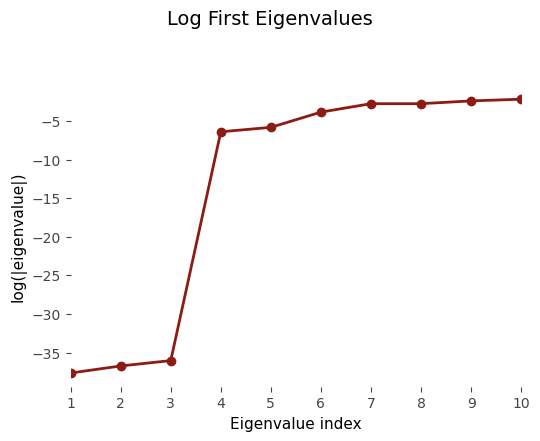

In [12]:
plot_eigenvalues([spectral_clustering_res.eigenvalues])

In [13]:
parameter_grid_fully_connected = {
    "sim_graph_type": ["fully_connect"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [
        # 0.01,
        # 0.02,
        # 0.03,
        # 0.04,
        # 0.05,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.4,
        0.5,
        0.6,
        0.75,
        1.0,
        1.5,
        2.0,
    ],
    "knn": [0],
    "mutual_knn": [0],
    "epsilon": [0],
}

parameter_grid_knn = {
    "sim_graph_type": ["knn"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [0],
    "knn": [3, 5, 6, 7, 8, 10, 12, 15, 17, 20, 23, 27, 30, 35, 40],
    "mutual_knn": [0],
    "epsilon": [0],
}

In [28]:
best_params_fully_connected = find_best_params_with_eigengap_grid_search(
    distance_matrix,
    param_grid=parameter_grid_fully_connected,
    random_state=1,
)
print(best_params_fully_connected)

best_params_knn = find_best_params_with_eigengap_grid_search(
    distance_matrix, param_grid=parameter_grid_knn, random_state=1
)
print(best_params_knn)

{'K': 3, 'epsilon': 0, 'knn': 0, 'mutual_knn': 0, 'sigma': 0.4, 'sim_graph_type': 'fully_connect'}
{'K': 2, 'epsilon': 0, 'knn': 10, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}


In [29]:
similarity_matrix_fully_connected = get_similarity_matrix_from_distance_matrix(
    distance_matrix,
    sim_graph_type=best_params_fully_connected["sim_graph_type"],
    sigma=best_params_fully_connected["sigma"],
)

res_fully_connected = Spectral_Clustering(
    similarity_matrix_fully_connected,
    K=3,
    random_state=1,
)

similarity_matrix_knn = get_similarity_matrix_from_distance_matrix(
    distance_matrix,
    sim_graph_type=best_params_knn["sim_graph_type"],
    knn=best_params_knn["knn"],
)

res_knn = Spectral_Clustering(
    similarity_matrix_knn,
    K=3,
    random_state=1,
)

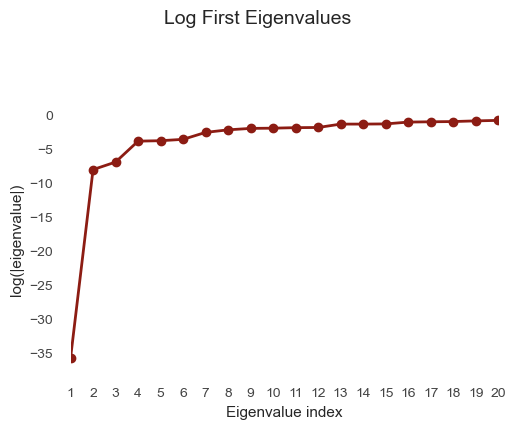

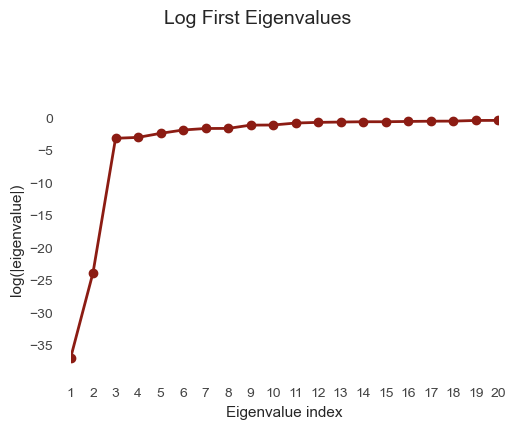

In [30]:
plot_eigenvalues([res_fully_connected.eigenvalues], n_first=20)
plot_eigenvalues([res_knn.eigenvalues], n_first=20)

In [50]:
# best_params_knn["knn"] = 10
best_params_fully_connected["K"] = 2

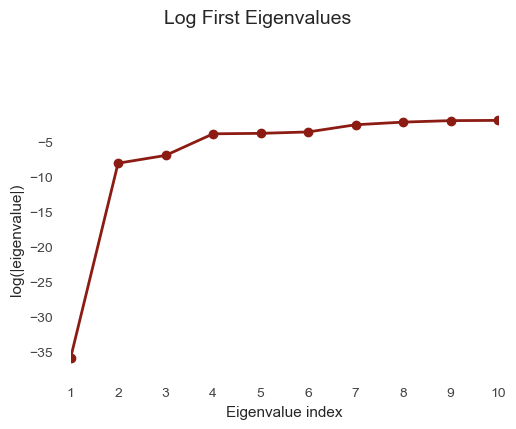

In [51]:
similarity_matrix_knn = get_similarity_matrix_from_distance_matrix(
    distance_matrix,
    sim_graph_type=best_params_fully_connected["sim_graph_type"],
    sigma=best_params_fully_connected["sigma"],
)

res = Spectral_Clustering(
    similarity_matrix_knn,
    K=best_params_fully_connected["K"],
    random_state=1,
)

plot_eigenvalues([res.eigenvalues])

In [52]:
K_folds = 10

stability_res_ami = cross_validation_stability_test(
    distance_matrix,
    params=best_params_fully_connected,
    K_folds=K_folds,
    info_score=adjusted_mutual_info_score,
)

stability_res_ars = cross_validation_stability_test(
    distance_matrix,
    params=best_params_fully_connected,
    K_folds=K_folds,
    info_score=adjusted_rand_score,
)

c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 1.0000
Mean info_score: 1.0000
Std  info_score: 0.0000


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 1.0000
Mean info_score: 1.0000
Std  info_score: 0.0000


In [53]:
stability_res_ami["std_score"], stability_res_ars["std_score"]

(0.0, 0.0)

<Axes: title={'center': 'Stability Across Folds'}, xlabel='Fold', ylabel='Stability Score'>

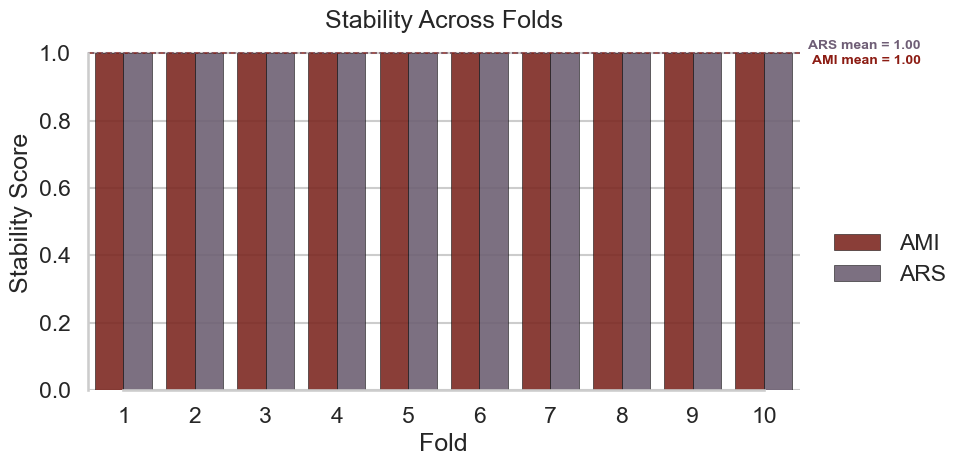

In [54]:
plot_cross_validation_stability_test_result(stability_res_ami, stability_res_ars)

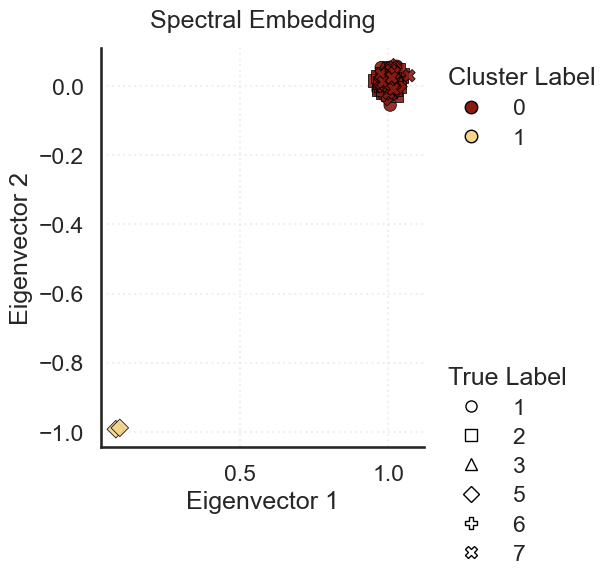

In [56]:
row_norms = np.linalg.norm(res.eigenvectors, axis=1, keepdims=True)
row_norms[row_norms == 0] = 1e-25

normalized_embedding = res.eigenvectors / row_norms

plot_2d_spectral_embedding(
    normalized_embedding, cluster_labels=res.labels, true_labels=y_true
)

# plot_3d_spectral_embedding(
#     normalized_embedding, cluster_labels=res.labels, true_labels=y_true
# )